# Exploratory Data Analysis – Fraud Datasets

In [28]:
#!pip install "protobuf>=5.28.3,<6"
#!pip install tensorflow==2.15.0
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.15.0 --no-cache-dir
#!pip uninstall tensorflow tensorflow-gpu protobuf keras -y
#!pip install protobuf==3.20.3
#!pip install tensorflow==2.15.0

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 1. DATA CLEANING MODULE

In [30]:
"""
Fraud Detection Project - Data Analysis & Visualization Module
Comprehensive EDA with cleaning and visual insights
"""

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class FraudDataCleaner:
    """
    Handles data quality issues and cleaning operations

    Why cleaning matters:
    - Garbage in = garbage out for ML models
    - Outliers can break distance-based methods (LOF, OCSVM)
    - Missing values need strategy (impute? drop?)
    - Duplicates can bias training
    """

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.cleaning_report = {}

    def check_data_quality(self, df):
        """
        Comprehensive data quality assessment

        What we check:
        - Missing values (could indicate data collection issues)
        - Duplicates (could indicate system errors or replay attacks)
        - Outliers (legitimate extreme values vs errors)
        - Data types (wrong types cause errors)
        - Cardinality (too many unique values = not useful)
        """
        print("\n" + "="*70)
        print(f"DATA QUALITY REPORT - {self.dataset_name}")
        print("="*70)

        # BASIC INFO
        print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

        # MISSING VALUES
        print("\nMissing Values Check:")
        missing = df.isnull().sum()
        missing_pct = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            'Column': missing.index,
            'Missing_Count': missing.values,
            'Missing_Percentage': missing_pct.values
        })
        missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(
            'Missing_Count', ascending=False
        )

        if len(missing_df) > 0:
            print(missing_df.to_string(index=False))
            self.cleaning_report['has_missing'] = True
        else:
            print("No missing values found!")
            self.cleaning_report['has_missing'] = False

        # DUPLICATES
        print("\n Duplicate Rows Check:")
        n_duplicates = df.duplicated().sum()
        dup_pct = (n_duplicates / len(df)) * 100
        print(f"Duplicate rows: {n_duplicates:,} ({dup_pct:.2f}%)")

        if n_duplicates > 0:
            print("Warning: Duplicates found -> removing")
            self.cleaning_report['n_duplicates'] = n_duplicates
        else:
            print("No duplicates found!")
            self.cleaning_report['n_duplicates'] = 0

        # DATA TYPES
        print("\nData Types:")
        dtype_counts = df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")

        # HIGH CARDINALITY COLUMNS
        print("\nHigh Cardinality Columns (may not be useful for ML):")
        for col in df.columns:
            if df[col].dtype == 'object':
                n_unique = df[col].nunique()
                # Columns with too many unique values (like IDs, names)
                # don't help ML models and increase dimensionality
                if n_unique > 100:
                    print(f"  {col}: {n_unique:,} unique values")

        # CONSTANT COLUMNS
        print("\nConstant or almost constant columns:")
        # They provide zero information (all values same)
        # Waste computation and can cause numerical issues
        for col in df.columns:
            if df[col].dtype in ['int64', 'float64']:
                n_unique = df[col].nunique()
                if n_unique == 1:
                    print(f"  {col}: Only 1 unique value (CONSTANT -> consider removing)")
                elif n_unique < 5:
                    print(f"  {col}: {n_unique} unique values (near-constant)")

        return self.cleaning_report

    def handle_missing_values(self, df, strategy='auto'):
        """
        Handle missing values intelligently

        Strategies:
        - 'auto': automatically choose best strategy per column
        - 'drop': drop rows with any missing values
        - 'median': impute numeric with median
        - 'mode': impute categorical with mode

        Why median over mean?
        - Robust to outliers (fraud data has many outliers)
        - Mean can be pulled by extreme fraudulent values
        """
        df = df.copy()

        if not df.isnull().any().any():
            print("\n No missing values to handle")
            return df

        print(f"\nHandling missing values (strategy: {strategy})...")

        for col in df.columns:
            missing_count = df[col].isnull().sum()

            if missing_count == 0:
                continue

            missing_pct = (missing_count / len(df)) * 100

            if strategy == 'auto':
                # If >50% missing, drop the column (too much information loss)
                if missing_pct > 50:
                    print(f"  {col}: Dropping column ({missing_pct:.1f}% missing)")
                    df = df.drop(columns=[col])

                # Numeric columns: use median (robust to outliers)
                elif df[col].dtype in ['int64', 'float64']:
                    median_val = df[col].median()
                    df[col].fillna(median_val, inplace=True)
                    print(f"  {col}: Filled with median ({missing_pct:.1f}% missing)")

                # Categorical columns: use mode (most frequent value)
                else:
                    mode_val = df[col].mode()[0]
                    df[col].fillna(mode_val, inplace=True)
                    print(f"  {col}: Filled with mode ({missing_pct:.1f}% missing)")

        return df

    def remove_duplicates(self, df):
        """
        Remove duplicate rows

        Why remove duplicates?
        - In fraud detection, duplicates could be:
          1. System errors (keep one copy)
          2. Replay attacks (actual fraud pattern)
        - We keep first occurrence and flag for investigation
        """
        n_before = len(df)
        df = df.drop_duplicates()
        n_after = len(df)
        n_removed = n_before - n_after

        if n_removed > 0:
            print(f"\n Removed {n_removed:,} duplicate rows")

        return df

    def detect_outliers(self, df, numeric_cols=None, method='iqr', threshold=3):
        """
        Detect outliers in numeric columns

        Methods:
        - 'iqr': Interquartile Range (Q3 - Q1)
          Outlier if: < Q1 - 1.5*IQR  OR  > Q3 + 1.5*IQR
          Robust to extreme values, works well for skewed data

        - 'zscore': Standard deviations from mean
          Outlier if: |z-score| > threshold (default 3)
          Works well for normally distributed data

        Note: In fraud detection, "outliers" might be frauds!
        Don't automatically remove - investigate instead
        """
        if numeric_cols is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns

        print(f"\nOutlier Detection (method: {method})...")

        outlier_summary = {}

        for col in numeric_cols:
            if method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1

                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            elif method == 'zscore':
                z_scores = np.abs(stats.zscore(df[col].dropna()))
                outliers = df[z_scores > threshold]

            n_outliers = len(outliers)
            pct_outliers = (n_outliers / len(df)) * 100

            if n_outliers > 0:
                print(f"  {col}: {n_outliers:,} outliers ({pct_outliers:.2f}%)")
                outlier_summary[col] = n_outliers

        return outlier_summary

    def clean_dataset(self, df, remove_dups=True, handle_missing=True):
        """
        Complete cleaning pipeline

        Steps:
        1. Check data quality
        2. Remove duplicates (if requested)
        3. Handle missing values (if requested)
        4. Report outliers (but don't remove - might be frauds!)
        """
        print("\n" + "="*70)
        print(f"CLEANING PIPELINE - {self.dataset_name}")
        print("="*70)

        # Step 1: Quality check
        self.check_data_quality(df)

        # Step 2: Remove duplicates
        if remove_dups:
            df = self.remove_duplicates(df)

        # Step 3: Handle missing values
        if handle_missing:
            df = self.handle_missing_values(df, strategy='auto')

        # Step 4: Detect outliers (report only, don't remove)
        numeric_cols = df.select_dtypes(include=[np.number]).columns[:5]  # Sample 5 cols
        self.detect_outliers(df, numeric_cols, method='iqr')

        print("\n" + "="*70)
        print(" CLEANING COMPLETED")
        print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print("="*70)

        return df

## 2. DATA VISUALIZATION MODULE

In [31]:
class FraudDataVisualizer:
    """
    Create insightful visualizations for fraud detection

    Goals:
    - Understand data distributions
    - Identify fraud patterns
    - Detect class imbalance
    - Find correlations between features
    """

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name

    def plot_target_distribution(self, y, title=None):
        """
        Visualize fraud vs normal distribution

        Why important?
        - Shows class imbalance (critical for fraud detection)
        - Determines if we need special techniques (SMOTE, class weights)
        - Sets expectations for model performance
        """
        if title is None:
            title = f"Fraud Distribution - {self.dataset_name}"

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Count plot
        fraud_counts = y.value_counts()
        axes[0].bar(['Normal', 'Fraud'], fraud_counts.values,
                   color=['blue', 'red'])
        axes[0].set_ylabel('Count')
        axes[0].set_title('Absolute Counts')
        axes[0].set_yscale('log')  # Log scale to see both classes clearly

        # Add count labels
        for i, v in enumerate(fraud_counts.values):
            axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

        # Percentage plot
        fraud_pct = y.value_counts(normalize=True) * 100
        axes[1].bar(['Normal', 'Fraud'], fraud_pct.values,
                   color=['blue', 'red'])
        axes[1].set_ylabel('Percentage (%)')
        axes[1].set_title('Distribution (%)')

        # Add percentage labels
        for i, v in enumerate(fraud_pct.values):
            axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\n Target Distribution:")
        print(f"  Normal: {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
        print(f"  Fraud:  {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
        print(f"  Imbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.0f}")

    def plot_numeric_distributions(self, df, y, n_cols=5, sample_size=10000):
        """
        Compare distributions between fraud and normal for numeric features

        Why useful?
        - See which features differ between fraud/normal
        - Identify discriminative features for modeling
        - Spot data quality issues (weird distributions)
        """
        numeric_cols = df.select_dtypes(include=[np.number]).columns[:n_cols]

        # Sample for faster plotting
        if len(df) > sample_size:
            sample_idx = np.random.choice(len(df), sample_size, replace=False)
            df_sample = df.iloc[sample_idx]
            y_sample = y.iloc[sample_idx]
        else:
            df_sample = df
            y_sample = y

        n_rows = (len(numeric_cols) + 1) // 2
        fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows))
        axes = axes.flatten()

        for idx, col in enumerate(numeric_cols):
            ax = axes[idx]

            # Plot distributions for fraud vs normal
            # Shows smooth distribution, easier to compare
            df_sample[y_sample == 0][col].hist(
                bins=30, alpha=0.5, label='Normal',
                color='blue', ax=ax, density=True
            )
            df_sample[y_sample == 1][col].hist(
                bins=30, alpha=0.5, label='Fraud',
                color='red', ax=ax, density=True
            )

            ax.set_xlabel(col)
            ax.set_ylabel('Density')
            ax.set_title(f'{col} Distribution')
            ax.legend()

        # Hide extra subplots
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Feature Distributions: Fraud vs Normal',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_correlation_matrix(self, df, figsize=(12, 10)):
        """
        Visualize feature correlations

        Why important?
        - Highly correlated features are redundant (multicollinearity)
        - Can simplify model by removing correlated features
        - Helps understand feature relationships

        What to look for:
        - Dark red/blue: strong positive/negative correlation
        - White/light: no correlation
        - Clusters: groups of related features
        """
        # Select numeric columns only
        numeric_df = df.select_dtypes(include=[np.number])

        # Calculate correlation matrix
        corr = numeric_df.corr()

        # Create mask for upper triangle (avoid redundancy)
        mask = np.triu(np.ones_like(corr, dtype=bool))

        # Plot
        plt.figure(figsize=figsize)
        sns.heatmap(
            corr,
            mask=mask,
            annot=False,  # Set True to see exact values (slow for many features)
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8}
        )
        plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Report highly correlated pairs
        print("\n Highly Correlated Feature Pairs (|r| > 0.8):")
        high_corr = []
        for i in range(len(corr.columns)):
            for j in range(i+1, len(corr.columns)):
                if abs(corr.iloc[i, j]) > 0.8:
                    high_corr.append({
                        'Feature 1': corr.columns[i],
                        'Feature 2': corr.columns[j],
                        'Correlation': corr.iloc[i, j]
                    })

        if high_corr:
            corr_df = pd.DataFrame(high_corr).sort_values(
                'Correlation', key=abs, ascending=False
            )
            print(corr_df.to_string(index=False))
        else:
            print("  No highly correlated pairs found")

    def plot_boxplots(self, df, y, n_cols=6, sample_size=10000):
        """
        Boxplots to compare fraud vs normal distributions

        Why boxplots?
        - Show median, quartiles, and outliers clearly
        - Easy to compare fraud vs normal side-by-side
        - Identify which features have different distributions

        What to look for:
        - Different medians = discriminative feature
        - Different spreads = different behaviors
        - Outliers in fraud = extreme fraud patterns
        """
        numeric_cols = df.select_dtypes(include=[np.number]).columns[:n_cols]

        # Sample for faster plotting
        if len(df) > sample_size:
            sample_idx = np.random.choice(len(df), sample_size, replace=False)
            df_sample = df.iloc[sample_idx].copy()
            df_sample['Fraud'] = y.iloc[sample_idx]
        else:
            df_sample = df.copy()
            df_sample['Fraud'] = y

        n_rows = (len(numeric_cols) + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
        axes = axes.flatten()

        for idx, col in enumerate(numeric_cols):
            ax = axes[idx]

            # Create boxplot
            df_sample.boxplot(
                column=col,
                by='Fraud',
                ax=ax,
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2)
            )

            ax.set_xlabel('Fraud (0=Normal, 1=Fraud)')
            ax.set_ylabel(col)
            ax.set_title(f'{col}')
            ax.get_figure().suptitle('')  # Remove default title

        # Hide extra subplots
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Feature Boxplots: Fraud vs Normal',
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()

    def plot_feature_importance_proxy(self, df, y, n_features=10):
        """
        Quick feature importance using correlation with target

        Why useful?
        - See which features correlate most with fraud
        - Guide feature selection
        - Understand what drives fraud

        Note: This is a proxy, not true feature importance
        Real importance comes from trained models (SHAP, permutation)
        """
        numeric_df = df.select_dtypes(include=[np.number])

        # Calculate correlation with target
        correlations = {}
        for col in numeric_df.columns:
            # Use absolute correlation (direction doesn't matter)
            correlations[col] = abs(numeric_df[col].corr(y))

        # Sort by correlation
        corr_sorted = pd.Series(correlations).sort_values(ascending=False)
        top_features = corr_sorted.head(n_features)

        # Plot
        plt.figure(figsize=(10, 6))
        colors = ['blue' if x > 0.3 else 'green' for x in top_features.values]
        top_features.plot(kind='barh', color=colors)
        plt.xlabel('Absolute Correlation with Fraud')
        plt.title(f'Top {n_features} Features by Correlation with Target',
                 fontsize=14, fontweight='bold')
        plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.5,
                   label='High correlation threshold')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"\n Top {n_features} Most Correlated Features:")
        for feat, corr in top_features.items():
            print(f"  {feat:30s}: {corr:.4f}")

    def create_full_eda_report(self, df, y, sample_size=10000):
        """
        Generate complete EDA report with all visualizations

        This is your one-stop-shop for understanding the data!
        """
        print("\n" + "="*70)
        print(f"EXPLORATORY DATA ANALYSIS - {self.dataset_name}")
        print("="*70)

        # 1. Target distribution
        self.plot_target_distribution(y)

        # 2. Numeric distributions
        print("\n Plotting feature distributions...")
        self.plot_numeric_distributions(df, y, n_cols=6, sample_size=sample_size)

        # 3. Correlation matrix
        print("\n Analyzing feature correlations...")
        self.plot_correlation_matrix(df, figsize=(12, 10))

        # 4. Boxplots
        print("\n Creating boxplots for fraud vs normal...")
        self.plot_boxplots(df, y, n_cols=6, sample_size=sample_size)

        # 5. Feature importance proxy
        print("\n Calculating feature importance...")
        self.plot_feature_importance_proxy(df, y, n_features=10)

        print("\n" + "="*70)
        print("EDA REPORT COMPLETED")
        print("="*70)

## 3. MAIN EXECUTION FOR DATA ANALYSIS

In [32]:
def analyze_fraud_data(dataset_choice='base', sample_size=None):
    """
    Complete data analysis pipeline

    Steps:
    1. Load data
    2. Clean data
    3. Generate visualizations
    4. Return cleaned data for modeling
    """
    print("\n" + "="*70)
    print("FRAUD DATA ANALYSIS PIPELINE")
    print("="*70)

    # Load data
    if dataset_choice == 'base':
        print("\n Loading Base.csv (Credit Dataset)...")
        df = pd.read_csv('Base.csv')
        target_col = 'fraud_bool'
    else:
        print("\n Loading Cifer Dataset (Transactions)...")
        df = pd.read_csv('Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv')
        target_col = 'isFraud'

    print(f"Original shape: {df.shape}")

    # Sample if needed
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
        print(f"Sampled to: {df.shape}")

    # Separate target
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # ========== CLEANING ==========
    cleaner = FraudDataCleaner(dataset_choice.upper())
    X_clean = cleaner.clean_dataset(X, remove_dups=True, handle_missing=True)

    # ========== VISUALIZATION ==========
    visualizer = FraudDataVisualizer(dataset_choice.upper())
    visualizer.create_full_eda_report(X_clean, y, sample_size=min(10000, len(X_clean)))

    print("\n Analysis complete! Data is ready for modeling.")

    return X_clean, y, cleaner, visualizer

## 1. DATA PREPROCESSING MODULE

## Feature Engineering
Raw data is not enough! We need to extract meaningful signals that highlight fraud patterns.

**Base.csv Feature**
1. Velocity Ratios
$$
velocity\_ratio\_6h\_24h = \frac{velocity\_6h}{velocity\_24h + 1}
$$
  - Fraudsters show sudden activity bursts (account takeover)
  - High ratio = recent activity spike = red flag
  - Legitimate users have stable velocity patterns
  
> Example:\
> Normal: 100 applications in 6h, 500 in 24h → ratio = 0.20\
> Fraud: 400 applications in 6h, 450 in 24h → ratio = 0.89

2. Address Stability
$$
address\_stability = \frac{current\_address\_months}{customer\_age}
$$
  - Fraudsters use temporary/fake addresses
  - Legitimate users stay years at same address
  - Normalizing by age accounts for young vs old customers

> Example:\
> Normal 30yo: lived 5 years at address → stability = 0.20\
> Fraud 30yo: lived 1 month at address → stability = 0.003

3. Binary Flags
$$
high\_velocity\_flag = velocity\_6h > 95^{th} percentile
$$
  - Create explicit signals for extreme behaviors
  - Help tree-based models make clear splits
  - Easy for meta-model to interpret


**Cifer (Transactions) Features**
1. Balance Changes
$$
balance\_change\_orig = newbalance - oldbalance
$$
  - In fraud: money leaves but balances don't match
  - System manipulation or fraudulent transfers
  - Inconsistencies reveal tampering
$$

> Example:\
> Transfer 1000€\
> Old balance: 1000€ → New balance: 1000€ (no change!)\
> Normal: Old 1000€ → New 0€

2. Amount to Balance Ratio
$$
amount\_to\_balance\_ratio = \frac{amount}{oldbalance}
$$
  - Legitimate users rarely empty accounts (ratio < 0.3)
  - Fraudsters drain accounts completely (ratio ≈ 1.0)
  - Classic "account takeover" signature

In [33]:
class FraudDataPreprocessor:
    """Handles data loading and preprocessing for both datasets"""

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.label_encoders = {}
        self.scaler = None

    def load_data(self, filepath):
        """Load dataset from CSV"""
        print(f"Loading {self.dataset_name}...")
        df = pd.read_csv(filepath)
        print(f"Shape: {df.shape}")
        return df

    def engineer_features_base(self, df):
        """Feature engineering for Base.csv (Credit dataset)"""
        df = df.copy()

        # Velocity ratios (acceleration indicators)
        df['velocity_ratio_6h_24h'] = df['velocity_6h'] / (df['velocity_24h'] + 1)
        df['velocity_ratio_24h_4w'] = df['velocity_24h'] / (df['velocity_4w'] + 1)

        # Address stability
        df['address_stability'] = df['current_address_months_count'] / (df['customer_age'] + 1)

        # Session behavior
        df['session_per_device'] = df['session_length_in_minutes'] / (df['device_distinct_emails_8w'] + 1)

        # Risk indicators
        df['high_velocity_flag'] = (df['velocity_6h'] > df['velocity_6h'].quantile(0.95)).astype(int)

        return df

    def engineer_features_cifer(self, df):
        """Feature engineering for Cifer dataset (Transactions)"""
        df = df.copy()

        # Balance changes
        df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
        df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

        # Amount ratios
        df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

        return df

    def encode_categorical(self, df, categorical_cols):
        """Encode categorical variables"""
        df = df.copy()

        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le

        return df

    def prepare_base_dataset(self, df, sample_size=None):
        """Complete preprocessing for Base.csv"""
        print("\n=== Preprocessing Base.csv (Credit Dataset) ===")

        # Sample if needed (for faster experimentation)
        if sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled to {sample_size} rows")

        # Feature engineering
        df = self.engineer_features_base(df)

        # Encode categorical variables
        categorical_cols = ['payment_type', 'employment_status', 'housing_status',
                           'source', 'device_os']
        df = self.encode_categorical(df, categorical_cols)

        # Separate features and target
        X = df.drop(['fraud_bool'], axis=1)
        y = df['fraud_bool']

        # Handle any remaining object columns
        X = X.select_dtypes(include=[np.number])

        print(f"Final feature shape: {X.shape}")
        print(f"Fraud rate: {y.mean():.4f}")

        return X, y

    def prepare_cifer_dataset(self, df, sample_size=None):
        """Complete preprocessing for Cifer dataset"""
        print("\n=== Preprocessing Cifer Dataset (Transactions) ===")

        # Sample if needed
        if sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled to {sample_size} rows")

        # Feature engineering
        df = self.engineer_features_cifer(df)

        # Encode transaction type
        df = self.encode_categorical(df, ['type'])

        # Drop name columns (high cardinality, not useful for modeling)
        cols_to_drop = ['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']
        X = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)
        y = df['isFraud']

        # Select numeric columns only
        X = X.select_dtypes(include=[np.number])

        print(f"Final feature shape: {X.shape}")
        print(f"Fraud rate: {y.mean():.4f}")

        return X, y

## Execution


FRAUD DATA ANALYSIS PIPELINE

 Loading Base.csv (Credit Dataset)...
Original shape: (1000000, 32)

CLEANING PIPELINE - BASE

DATA QUALITY REPORT - BASE

Dataset Shape: 1,000,000 rows × 31 columns

Missing Values Check:
No missing values found!

 Duplicate Rows Check:
Duplicate rows: 0 (0.00%)
No duplicates found!

Data Types:
  int64: 17 columns
  float64: 9 columns
  object: 5 columns

High Cardinality Columns (may not be useful for ML):

Constant or almost constant columns:
  email_is_free: 2 unique values (near-constant)
  phone_home_valid: 2 unique values (near-constant)
  phone_mobile_valid: 2 unique values (near-constant)
  has_other_cards: 2 unique values (near-constant)
  foreign_request: 2 unique values (near-constant)
  keep_alive_session: 2 unique values (near-constant)
  device_distinct_emails_8w: 4 unique values (near-constant)
  device_fraud_count: Only 1 unique value (CONSTANT -> consider removing)

 No missing values to handle

Outlier Detection (method: iqr)...
  prev

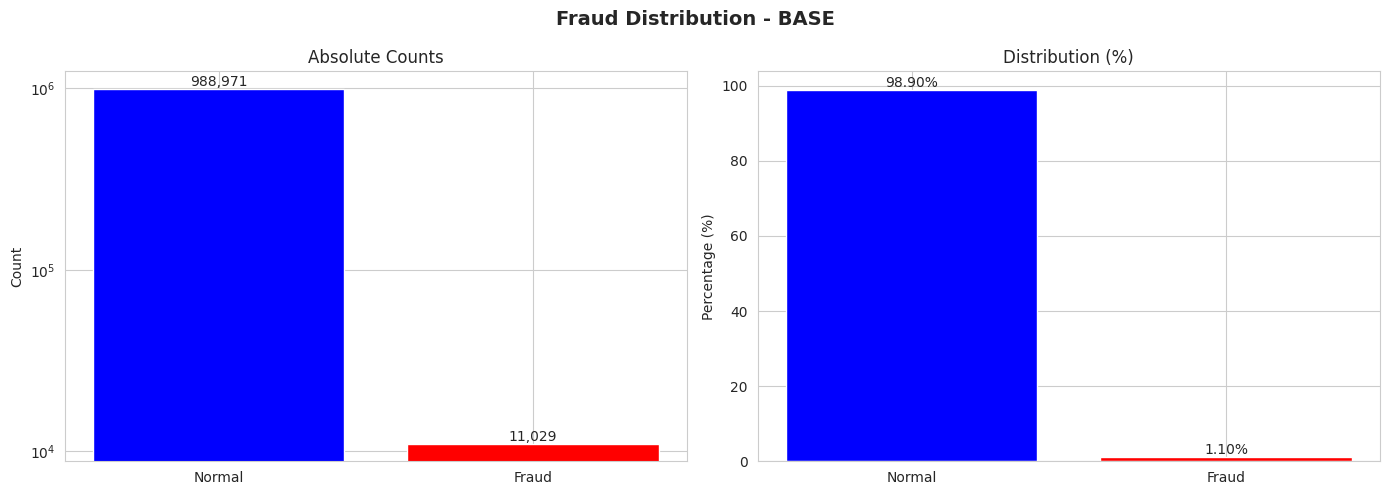


 Target Distribution:
  Normal: 988,971 (98.90%)
  Fraud:  11,029 (1.10%)
  Imbalance Ratio: 1:90

 Plotting feature distributions...


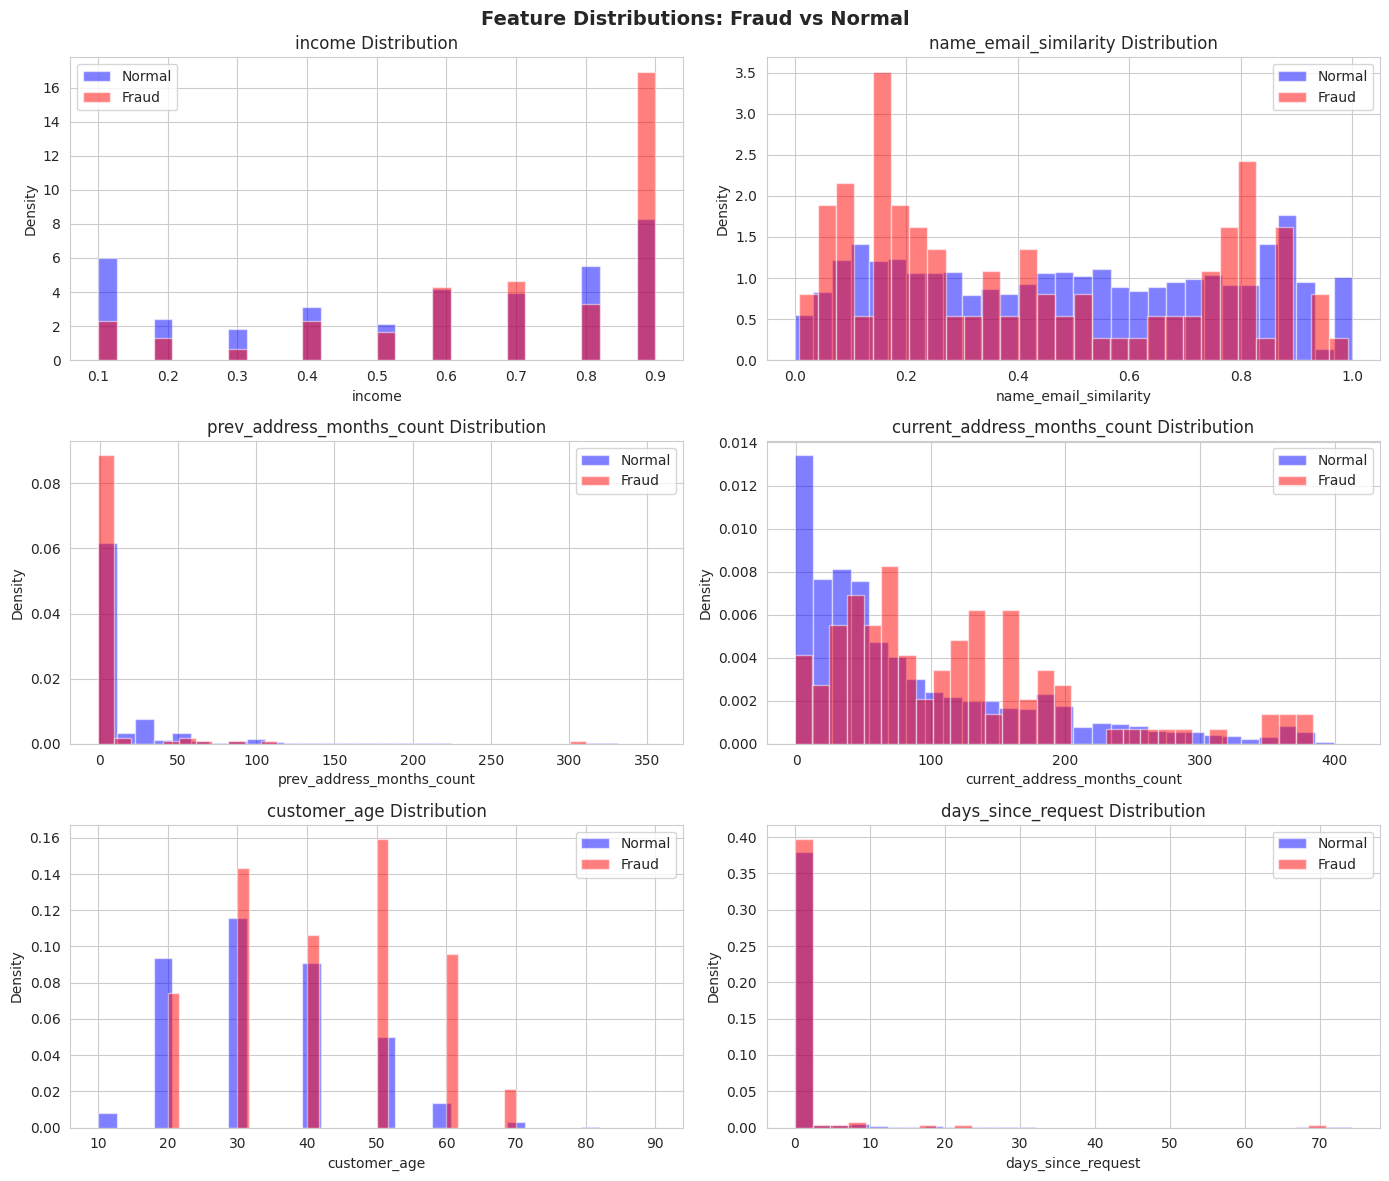


 Analyzing feature correlations...


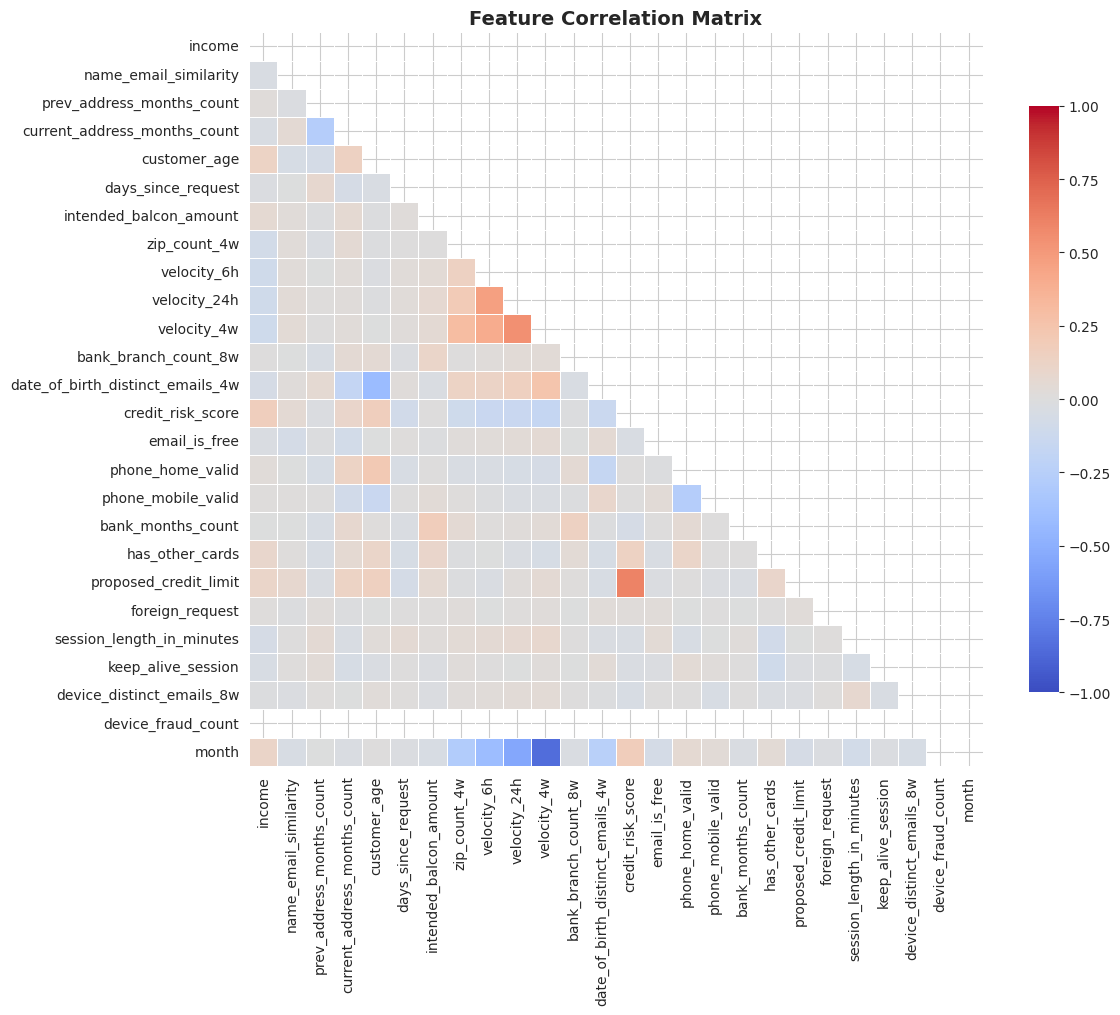


 Highly Correlated Feature Pairs (|r| > 0.8):
  Feature 1 Feature 2  Correlation
velocity_4w     month      -0.8481

 Creating boxplots for fraud vs normal...


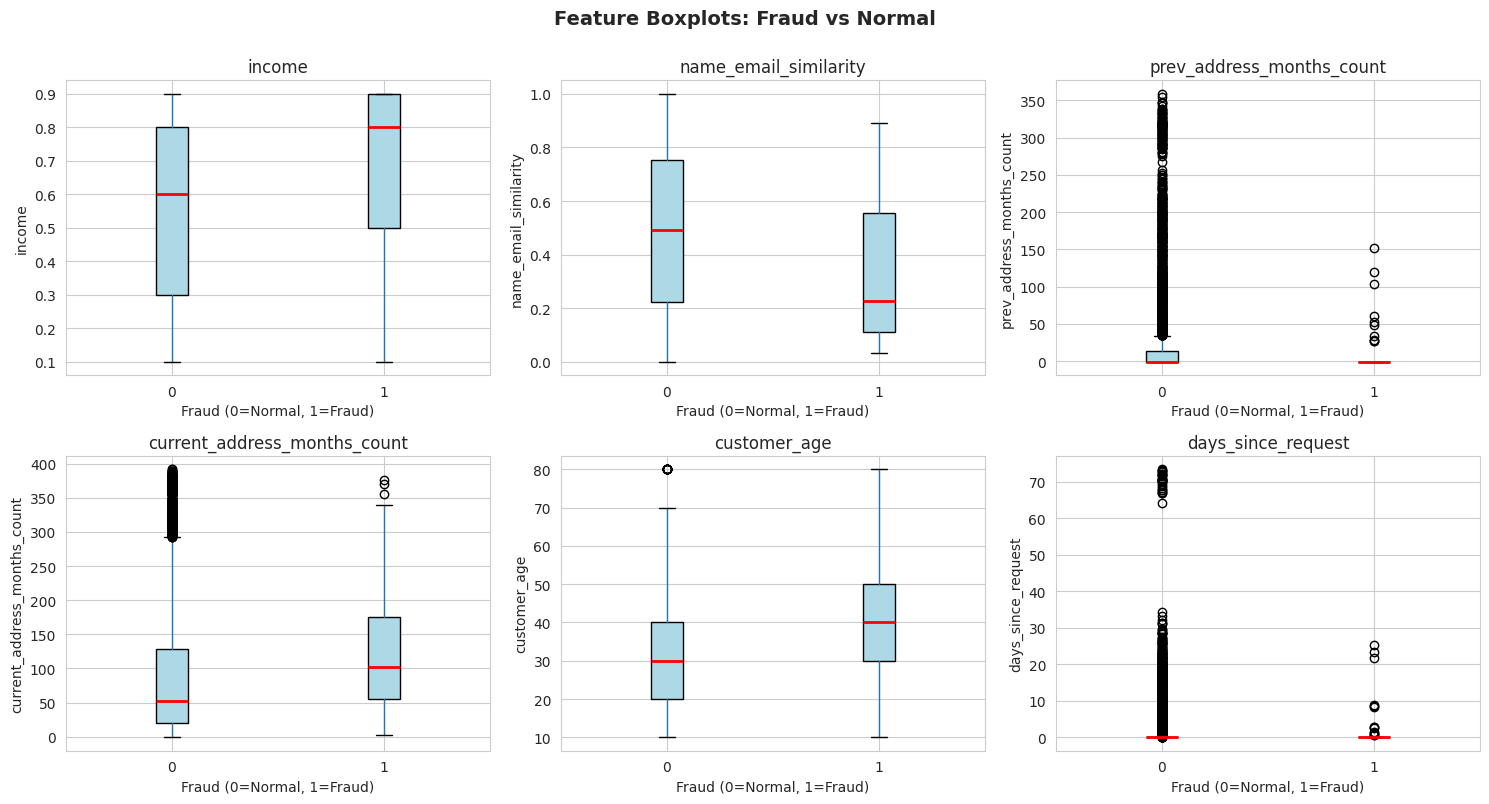


 Calculating feature importance...


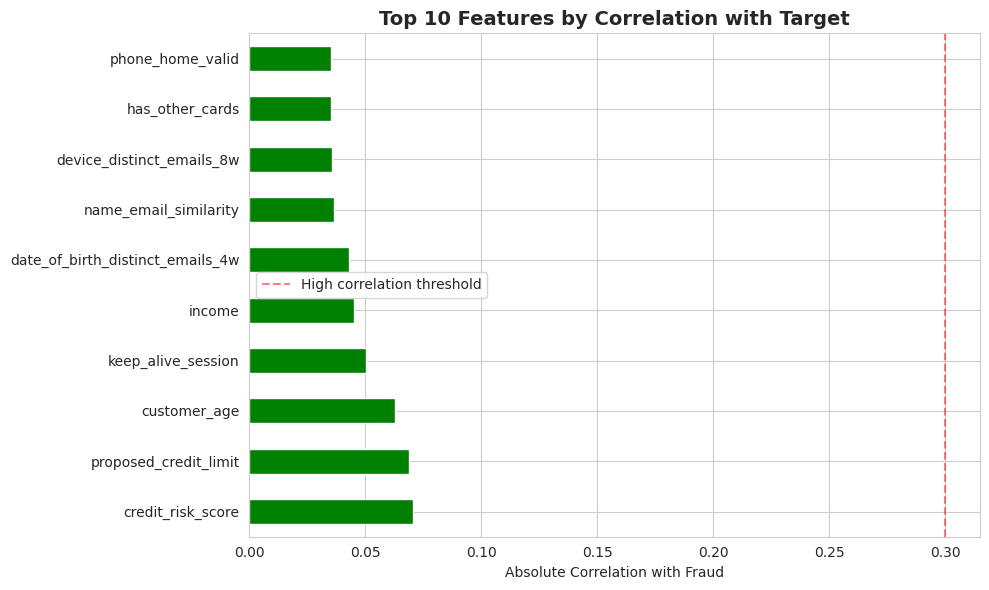


 Top 10 Most Correlated Features:
  credit_risk_score             : 0.0706
  proposed_credit_limit         : 0.0689
  customer_age                  : 0.0630
  keep_alive_session            : 0.0503
  income                        : 0.0451
  date_of_birth_distinct_emails_4w: 0.0432
  name_email_similarity         : 0.0367
  device_distinct_emails_8w     : 0.0357
  has_other_cards               : 0.0352
  phone_home_valid              : 0.0351

EDA REPORT COMPLETED

 Analysis complete! Data is ready for modeling.

FRAUD DATA ANALYSIS PIPELINE

 Loading Cifer Dataset (Transactions)...
Original shape: (1500000, 11)

CLEANING PIPELINE - CIFER

DATA QUALITY REPORT - CIFER

Dataset Shape: 1,500,000 rows × 10 columns

Missing Values Check:
No missing values found!

 Duplicate Rows Check:
Duplicate rows: 0 (0.00%)
No duplicates found!

Data Types:
  float64: 5 columns
  object: 3 columns
  int64: 2 columns

High Cardinality Columns (may not be useful for ML):
  nameOrig: 1,481,624 unique value

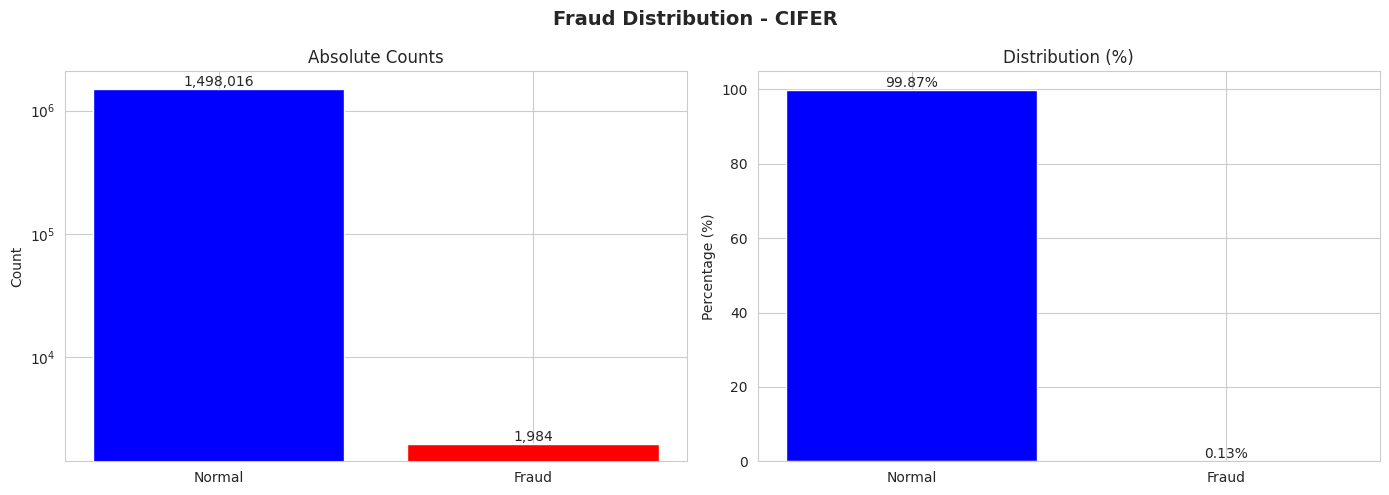


 Target Distribution:
  Normal: 1,498,016 (99.87%)
  Fraud:  1,984 (0.13%)
  Imbalance Ratio: 1:755

 Plotting feature distributions...


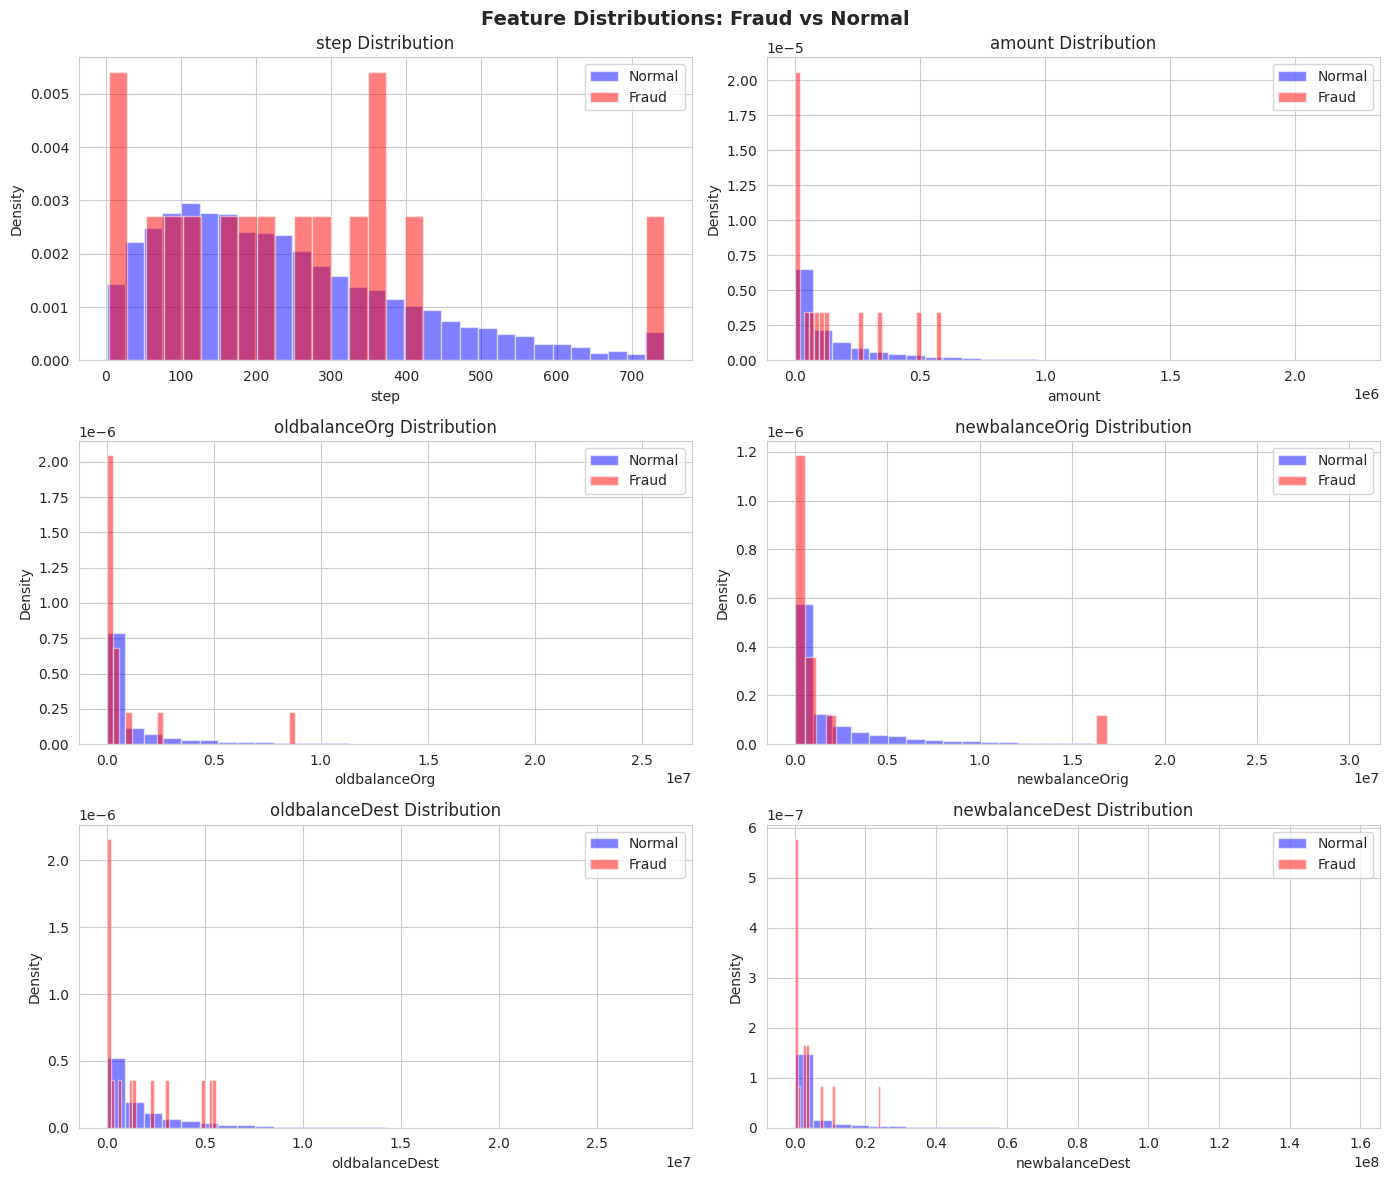


 Analyzing feature correlations...


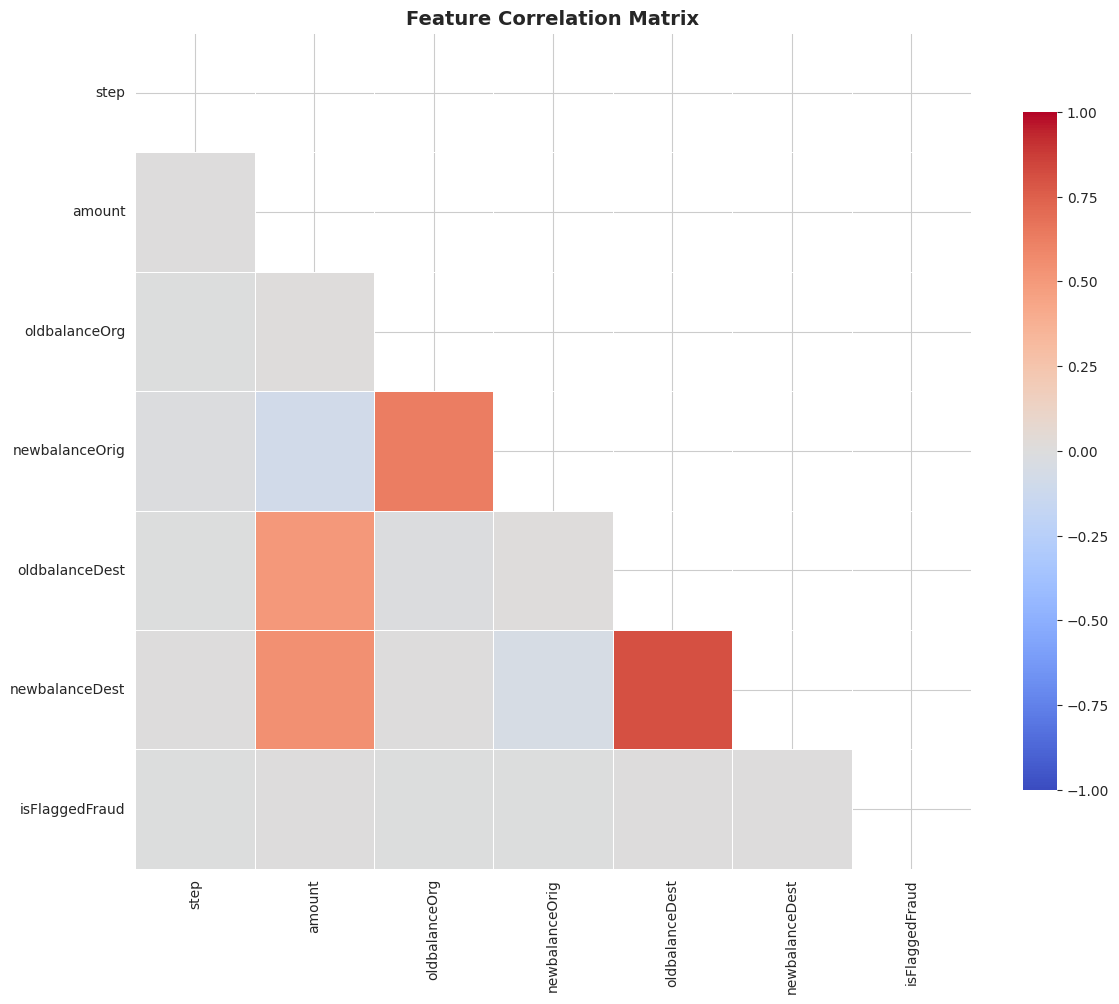


 Highly Correlated Feature Pairs (|r| > 0.8):
     Feature 1      Feature 2  Correlation
oldbalanceDest newbalanceDest     0.805084

 Creating boxplots for fraud vs normal...


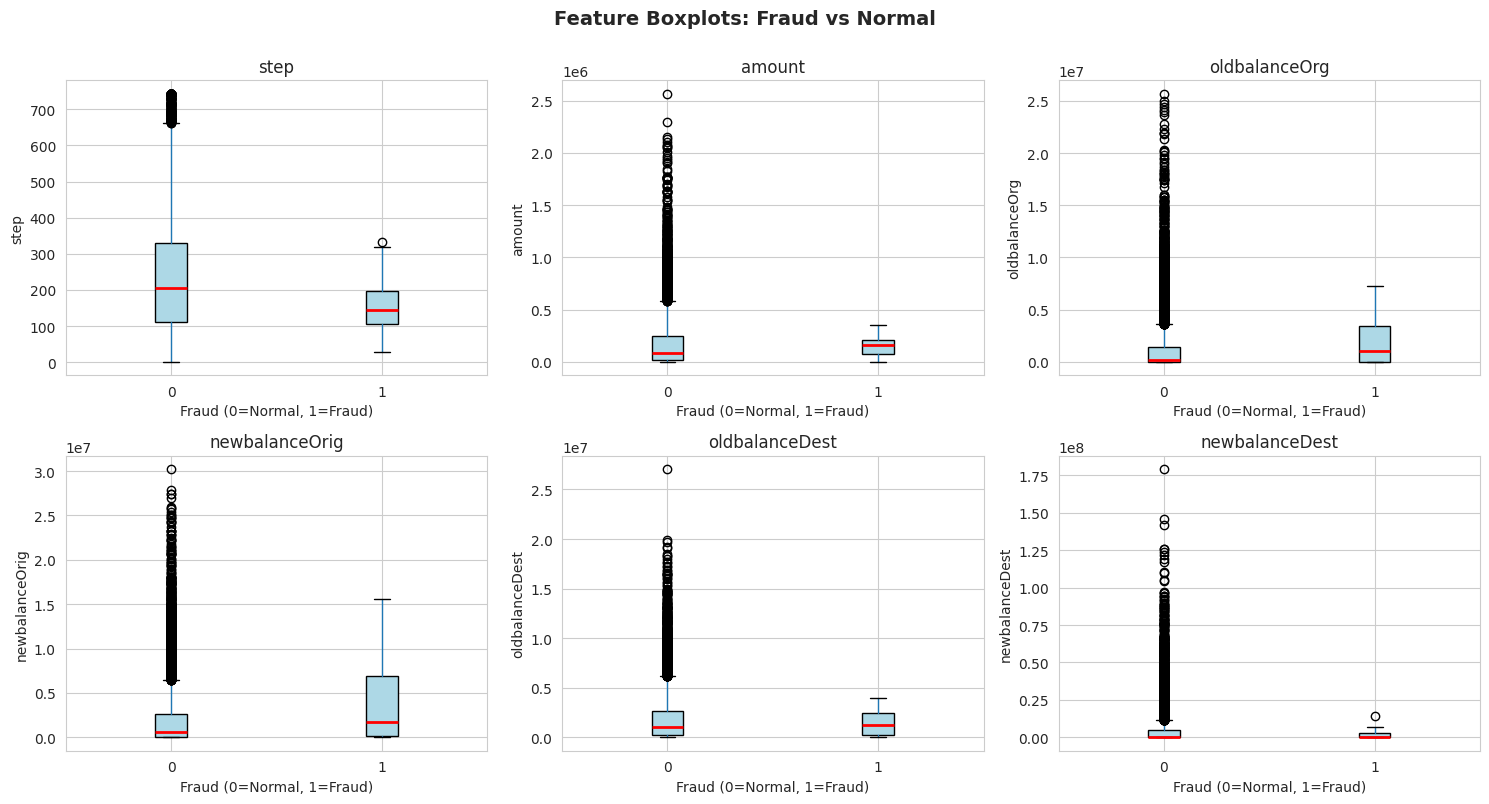


 Calculating feature importance...


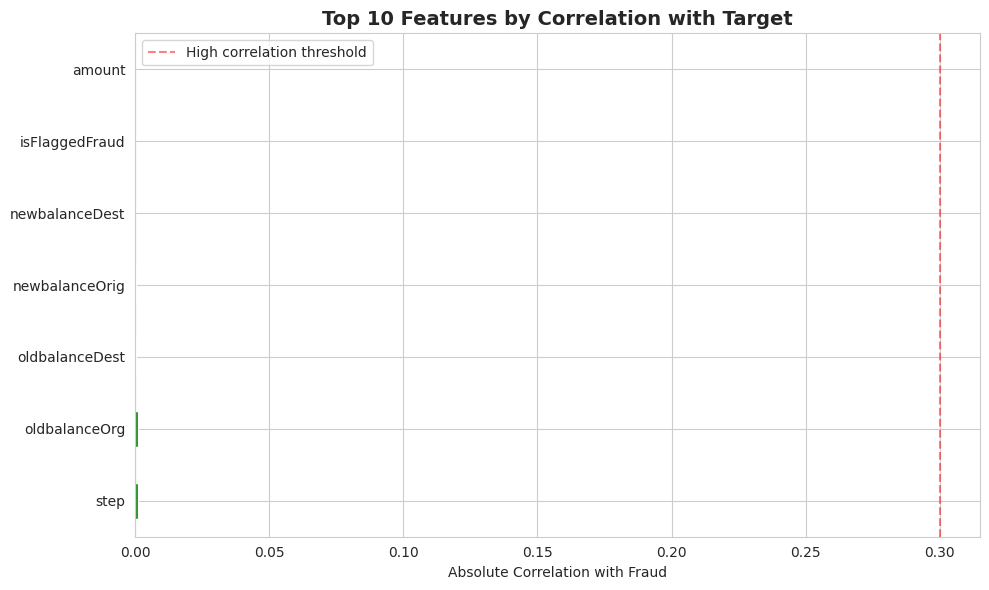


 Top 10 Most Correlated Features:
  step                          : 0.0010
  oldbalanceOrg                 : 0.0009
  oldbalanceDest                : 0.0005
  newbalanceOrig                : 0.0002
  newbalanceDest                : 0.0001
  isFlaggedFraud                : 0.0001
  amount                        : 0.0000

EDA REPORT COMPLETED

 Analysis complete! Data is ready for modeling.

Cleaned data ready for Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv: (1500000, 10)
Target ready for Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv: (1500000,)

=== Preprocessing Base.csv (Credit Dataset) ===
Final feature shape: (1000000, 36)
Fraud rate: 0.0110

=== Preprocessing Cifer Dataset (Transactions) ===
Final feature shape: (1500000, 10)
Fraud rate: 0.0013


In [34]:
if __name__ == "__main__":
    # Analyze Base.csv
    X_base_clean, y_base, cleaner_base, viz_base = analyze_fraud_data(
        dataset_choice='base'
    )

    # Analyze Base.csv
    X_cifer_clean, y_cifer, cleaner_cifer, viz_cifer = analyze_fraud_data(
        dataset_choice='cifer'
    )

    # We can now use X_clean and y
    print(f"\nCleaned data ready for Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv: {X_cifer_clean.shape}")
    print(f"Target ready for Cifer-Fraud-Detection-Dataset-AF-part-1-14.csv: {y_cifer.shape}")

    preprocessor_base = FraudDataPreprocessor('Base')
    # Recombine X_base_clean and y_base into a single DataFrame for prepare_base_dataset
    full_base_df = pd.concat([X_base_clean, y_base], axis=1)
    X_base, y_base = preprocessor_base.prepare_base_dataset(full_base_df)

    preprocessor_cifer = FraudDataPreprocessor('Cifer')
    # Recombine X_cifer_clean and y_cifer into a single DataFrame for prepare_cifer_dataset
    full_cifer_df = pd.concat([X_cifer_clean, y_cifer], axis=1)
    X_cifer, y_cifer = preprocessor_cifer.prepare_cifer_dataset(full_cifer_df)